# Estimating sea ice thickness and its uncertainty with ICESat-2



* Notebook author: Alek Petty
* Description: Notebook describing the conversion of ICESat-2 ATL10 freebaords to sea ice thickness using NESOSIM snow depth/density estimates,  including random/systematic uncertainity estimates.
* Input requirements: Demo ATL10 data file, NESOSIM snow depths.
* Date: March 2021
* Reference: Petty, A. A., N. T. Kurtz, R. Kwok, T. Markus, T. A. Neumann (2020), Winter Arctic sea ice thickness from ICESat‐2 freeboards, Journal of Geophysical Research: Oceans, 125, e2019JC015764. doi:10.1029/2019JC015764 


## Notebook objectives
* General understanding of converting sea ice freeboard to thickness
* Estimating sea ice thickness uncertainties.



In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')
import cartopy.crs as ccrs
import h5py
import scipy
from astropy.time import Time
import utils as ut


#Magic function to enable interactive plotting in Jupyter notebook
%matplotlib inline

#### Import Data

As in the ATL07 Notebook, you can either get the data for this tutorial from the tutorial-data/sea-ice/ folder (at the hackweek) or download from NSIDC if you are running this on your local machine

## ICESat-2 freeboards (ATL10)

ATL10 is a pretty simple product, with most of the hard work done in ATL03 and then ATL07. ATL10 essentially returns the freeboard of the height segments calculated in ATL07 - the difference in height between the ice and sea surface. A local sea surface height is calculated in 10 km along-track sections using all relevant sea surface heights (ssh_flag) in each beam. 

A lot of the important variables in ATL07 have been passed through to ATL10 making this a useful high-level data product of interest to the community.

In [2]:
data_loc='./'
fname='ATL10-01_20190301101224_09620201_003_03.h5'
fileT= data_loc+fname

#### Read in the data using the pandas reader above. Copied from the readers.py script.

* Take a look at the top few rows (change the number in head to increase this..)    
* Play around with the max/min freeboards. Note how without this we get some very large NaNs at the start of the granule. You could change the reader and set these to np.nan instead of just removing those rows if you want.
* Any other variables you might want to use?

In [3]:
beamStr='gt1r'
epsg_string='3411'
dF10 = ut.get_atl10_freeboards(fileT, beam=beamStr, epsg_string=epsg_string)
dF10.head()

ATL10 file: ./ATL10-01_20190301101224_09620201_003_03.h5


,freeboard,freeboard_sigma,freeboard_quality,ssh_flag,lon,lat,height_segment_id,datetime,seg_x,xpts,ypts
0,0.239040,0.1,1,0,163.836764,77.026653,68278,2019-03-01 10:39:18.161553,11470.050390,-680639.451873,1.236199e+06
1,0.238114,0.1,1,0,163.836520,77.026340,68279,2019-03-01 10:39:18.166543,11470.085817,-680650.726639,1.236232e+06
2,0.233722,0.1,1,0,163.836196,77.025924,68280,2019-03-01 10:39:18.173188,11470.133003,-680665.747996,1.236276e+06
3,0.234718,0.1,1,0,163.835992,77.025662,68281,2019-03-01 10:39:18.177366,11470.162673,-680675.200836,1.236303e+06
4,0.236468,0.1,1,0,163.835763,77.025367,68282,2019-03-01 10:39:18.182068,11470.196056,-680685.847063,1.236334e+06


In [4]:
date_str = dF10.datetime.iloc[0].strftime("%Y%m%d") 
print('Start date of granule', date_str)

Start date of granule 20190301


#### Map the data for visual inspection using Cartopy 
*NB (Basemap is often used for mapping but is not being officially supported by the community anymore) so we've tried to focus on Cartopy here*

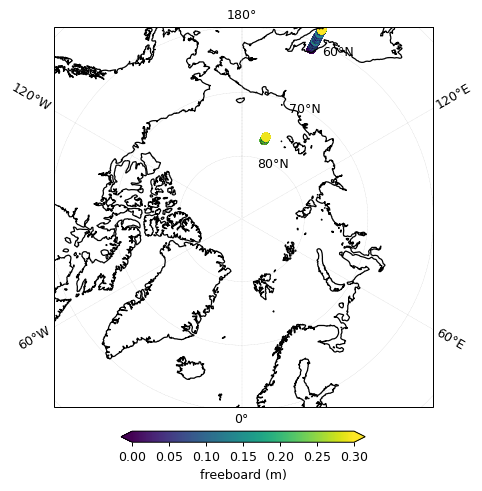

In [5]:
var='freeboard'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
# ccrs.PlateCarree
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10['lon'], dF10['lat'],c=dF10[var], cmap='viridis', vmin=0, vmax=0.3, transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
ax.gridlines(draw_labels=True,
              linewidth=0.22, color='gray', alpha=0.5, linestyle='--')
plt.colorbar(label=var+' (m)', shrink=0.5, pad=0.05, orientation="horizontal", extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

#### Let's convert the ATL10 freeboards to sea ice thickness!

* First we read in NESOSIM snow depth and density data to each row (segment) of data (https://github.com/akpetty/NESOSIM)
* We then convert the freeboard to thickness using the Warren snow depth/density. The function this calls assumes the sea ice is in hydrostatic equlibirum. Why/when might this be invalid?


In [6]:
# First grab and apply the relevant NESOSIM snow depth and density

nesosim_path = './NESOSIMv11_01092018-30042019.nc'
# Get NESOSIM data for the given day
nesosim_day=ut.get_nesosim(date_str, nesosim_path)

dF10 = ut.grid_NESOSIM_to_freeboard(dF10, nesosim_day, epsg_string = epsg_string, outSnowVar='snow_depth_N', outDensityVar='snow_density_N', returnMap=False)

dF10.head()

./NESOSIMv11_01092018-30042019.nc
<xarray.Dataset>
Dimensions:            (x: 90, y: 90)
Coordinates:
    day                int32 20190301
Dimensions without coordinates: x, y
Data variables: (12/13)
    projection         int32 ...
    forcings           int32 ...
    parameters         int32 ...
    longitude          (x, y) float32 ...
    latitude           (x, y) float32 ...
    xgrid              (x, y) float32 ...
    ...                 ...
    snow_depth         (x, y) float32 ...
    snow_volume        (x, y) float32 ...
    snow_density       (x, y) float32 ...
    snowfall           (x, y) float32 ...
    ice_concentration  (x, y) float32 ...
    wind_speed         (x, y) float32 ...
Attributes:
    reference:    github.com/akpetty/NESOSIM
    contact:      alek.a.petty@nasa.gov
    description:  Daily snow on sea ice (depth and density) from the NASA Eul...
    history:      Created 02/03/21
    data_range:   Date range: 20180901-20190430


,freeboard,freeboard_sigma,freeboard_quality,ssh_flag,lon,lat,height_segment_id,datetime,seg_x,xpts,ypts,snow_depth_N,snow_density_N
0,0.239040,0.1,1,0,163.836764,77.026653,68278,2019-03-01 10:39:18.161553,11470.050390,-680639.451873,1.236199e+06,0.0975,322.913788
1,0.238114,0.1,1,0,163.836520,77.026340,68279,2019-03-01 10:39:18.166543,11470.085817,-680650.726639,1.236232e+06,0.0975,322.913788
2,0.233722,0.1,1,0,163.836196,77.025924,68280,2019-03-01 10:39:18.173188,11470.133003,-680665.747996,1.236276e+06,0.0975,322.913788
3,0.234718,0.1,1,0,163.835992,77.025662,68281,2019-03-01 10:39:18.177366,11470.162673,-680675.200836,1.236303e+06,0.0975,322.913788
4,0.236468,0.1,1,0,163.835763,77.025367,68282,2019-03-01 10:39:18.182068,11470.196056,-680685.847063,1.236334e+06,0.0975,322.913788


In [7]:
int(date_str[4:6])

3

In [8]:
# ADD something about ice density??
dF10=ut.convert_to_thickness(dF10, snowDepthVar='snow_depth_N', 
                                 snowDensityVar='snow_density_N',
                                 outVar='ice_thickness_N', rhoi=1)

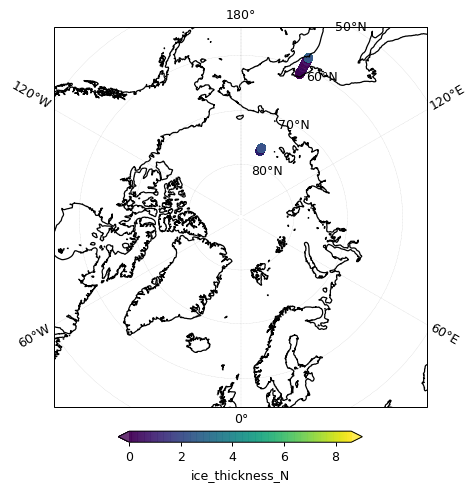

In [9]:
# Map the data for visual inspection using Cartopy
var='ice_thickness_N'
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(dF10['lon'], dF10['lat'],c=dF10[var], cmap='viridis', alpha=0.8, transform=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True,
              linewidth=0.22, color='gray', alpha=0.5, linestyle='--')
plt.colorbar(label=var, shrink=0.5, pad=0.05, orientation="horizontal", extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 55], ccrs.PlateCarree())

In [10]:
dF10 = ut.calc_thickness_uncertainty(dF10, 'snow_depth_N', 'snow_density_N', 'ice_density_1', 'ice_thickness_N_unc', 
                                     snow_depth_unc_sys_default=0.1, snow_density_unc_sys_default=30, ice_density_unc_sys_default=10, 
                                     freeboard_unc_sys_default=0.01, seawater_density=1024., snow_depth_unc_random=0.05, snow_density_unc_random=40, 
                                     ice_density_unc_random=10., water_density_unc_random=0.5)
dF10.head()

,freeboard,freeboard_sigma,freeboard_quality,ssh_flag,lon,lat,height_segment_id,datetime,seg_x,xpts,ypts,snow_depth_N,snow_density_N,ice_density_1,ice_thickness_N,freeboard_unc,ice_thickness_N_uncrandom,ice_thickness_N_uncsys,ice_thickness_N_unc
0,0.239040,0.1,1,0,163.836764,77.026653,68278,2019-03-01 10:39:18.161553,11470.050390,-680639.451873,1.236199e+06,0.0975,322.913788,916.0,1.633525,0.100499,1.014158,0.673796,1.217587
1,0.238114,0.1,1,0,163.836520,77.026340,68279,2019-03-01 10:39:18.166543,11470.085817,-680650.726639,1.236232e+06,0.0975,322.913788,916.0,1.624753,0.100499,1.014037,0.673614,1.217386
2,0.233722,0.1,1,0,163.836196,77.025924,68280,2019-03-01 10:39:18.173188,11470.133003,-680665.747996,1.236276e+06,0.0975,322.913788,916.0,1.583107,0.100499,1.013472,0.672764,1.216444
3,0.234718,0.1,1,0,163.835992,77.025662,68281,2019-03-01 10:39:18.177366,11470.162673,-680675.200836,1.236303e+06,0.0975,322.913788,916.0,1.592548,0.100499,1.013599,0.672955,1.216656
4,0.236468,0.1,1,0,163.835763,77.025367,68282,2019-03-01 10:39:18.182068,11470.196056,-680685.847063,1.236334e+06,0.0975,322.913788,916.0,1.609140,0.100499,1.013824,0.673293,1.217030


In [15]:
# cut to middle part of the granule
minlat=76.8
maxlat=80
dF10=dF10[(dF10.lat>minlat)&(dF10.lat<maxlat)]

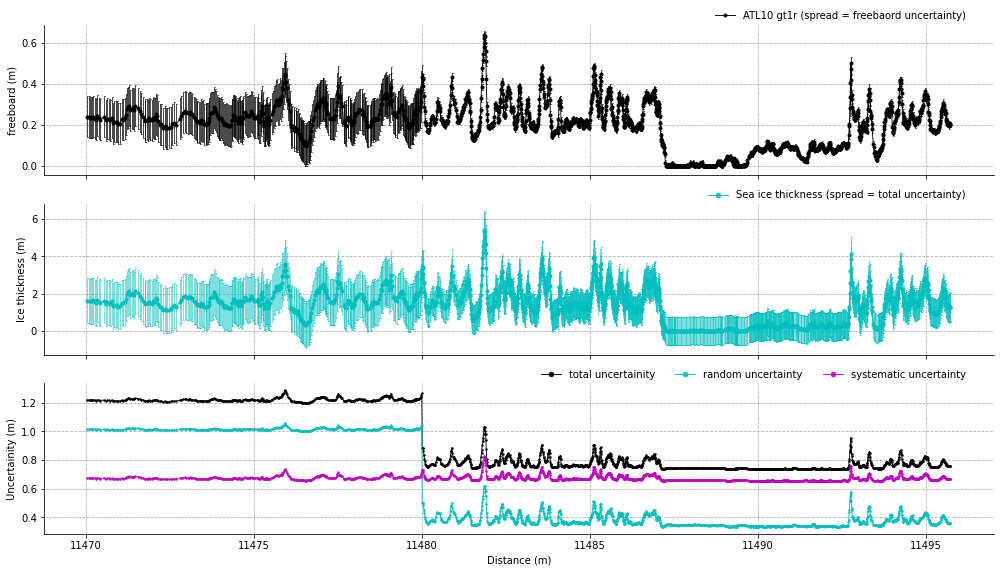

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))

plt.sca(axs.flatten()[0])
ax1=plt.gca()
ax1.plot(dF10['seg_x'].values, dF10['freeboard'].values, '.-', color='k', alpha=0.9, label='ATL10 '+beamStr+' (spread = freeboard uncertainty)', markersize=2, linewidth=1)
ax1.errorbar(dF10['seg_x'].values, dF10['freeboard'].values, yerr=dF10['freeboard_sigma'].values, fmt='', linestyle='', marker='.', color='k', lw=0.7, capsize=0.5)

# add panel indicating ice type
ax1.set_ylabel('freeboard (m)')
#ax1.set_yticks(np.arange(0, 1.5, 0.5))
ax1.set_xticklabels([])

plt.sca(axs.flatten()[1]) 
ax2=plt.gca()

ax2.plot(dF10['seg_x'].values, dF10['ice_thickness_N'].values, '.-', color='r', alpha=0.9,label=r'Sea ice thickness (spread = total uncertainty)', markersize=3, linewidth=1)
ax2.errorbar(dF10['seg_x'].values, dF10['ice_thickness_N'].values, yerr=dF10['ice_thickness_N_unc'].values, fmt='', linestyle='', marker='.', color='r', lw=0.5, capsize=0.5,)
#ax1.errorbar(dist, IS2data['ice_thickness_N'].values, yerr=IS2data['freeboard_sigma'].values, fmt='', linestyle='', marker='.', color='k', lw=0.5, capsize=0.5,)

ax2.set_ylabel('Ice thickness (m)')
ax2.set_xticklabels([])


plt.sca(axs.flatten()[2]) 
ax3=plt.gca()
ax3.plot(dF10['seg_x'].values, dF10['ice_thickness_N_unc'].values, '.-', alpha=0.9, label='total uncertainity', color='k', markersize=3, linewidth=1)
ax3.plot(dF10['seg_x'].values, dF10['ice_thickness_N_uncrandom'].values, '.-', alpha=0.9, label='random uncertainty', color='c', markersize=3, linewidth=1)
ax3.plot(dF10['seg_x'].values, dF10['ice_thickness_N_uncsys'].values, '.-', alpha=0.9, label='systematic uncertainty', color='m', markersize=3, linewidth=1)

ax3.set_ylabel('Uncertainity (m)')
ax3.set_xlabel('Distance (m)')

ax1.legend(loc=1, ncol=1, markerscale=3, bbox_to_anchor=[0.98, 1.15], labelspacing=0.45, frameon=False)
ax2.legend(loc=1, ncol=6, markerscale=3, bbox_to_anchor=[0.98, 1.15], labelspacing=0.45, frameon=False)
ax3.legend(loc=1, ncol=6, markerscale=3, bbox_to_anchor=[0.98, 1.15], labelspacing=0.45, frameon=False)

# Common subplot additions
for ax in axs.flatten():
    plt.sca(ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    #ax.set_xlim([0, 1000])
    ax.yaxis.set_ticks_position('left')
    ax.grid(axis='both', linestyle='--')

#ax1.annotate(titleStr, xy=(0.01, 1.01), xycoords='axes fraction', horizontalalignment='left', verticalalignment='bottom')
plt.tight_layout()
#subplots_adjust(left = 0.07, right = 0.98, bottom=0.07, top = 0.96, hspace=0.18)
plt.show()
